In [152]:
'''Compare Assessor SQFT to OSM and LARIAC for yearly roll by landbase geoms'''

'Compare Assessor SQFT to OSM and LARIAC for yearly roll by landbase geoms'

In [2]:
import os
os.chdir('../..')

In [3]:
from src.geoadmin import load_neighborhoods, load_cities

cities = load_cities().to_crs(4326)
hoods = load_neighborhoods()

In [ ]:
'''select sample neighborhood '''

import geopandas as gpd
import matplotlib.pyplot as plt

lacity = cities.query('CITYNAME_ALF == "LOS ANGELES"')
hoodnames = gpd.sjoin(hoods.set_geometry(hoods.centroid),
                         lacity[['geometry']],
                        #  predicate='within'
                         )['name'].tolist()

lacity_hood = hoods.query('name == @hoodnames[0]')
polygon_geometry = lacity_hood.iloc[0].geometry

/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_74914/1721715944.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lacity_hoodsnames = gpd.sjoin(hoods.set_geometry(hoods.centroid),


In [269]:
from src.geoadmin import get_landbase_layer
get_landbase_layer()

{2011: 'Landbase2011',
 2012: 'Landbase2012',
 2013: 'Landbase2013',
 2016: 'Landbase2016',
 2017: 'Landbase2017',
 2018: 'Landbase2018',
 2021: 'Landbase_Dec2021',
 2022: 'Landbase_Dec2022',
 2023: 'Landbase_Dec2023',
 2024: 'Landbase_Dec2024',
 2025: 'LANDBASE_June2025'}

In [288]:
import numpy as np

def load_data_by_year(lb_yr, apd_yr, lar_yr, source = 'lariac'):

    from src.geoadmin import get_landbase_bymask
    landbase_parcels = get_landbase_bymask(lacity_hood, lb_yr)

    from src.geoadmin import load_assessor_parcels_bygeom
    assessor_data= load_assessor_parcels_bygeom(polygon_geometry).to_crs(landbase_parcels.crs)
    assessor_data = assessor_data[assessor_data.RollYear == apd_yr]

    if source == 'lariac':
        from src.geoadmin import load_laraic
        lariac_structures = load_laraic(lacity_hood, lar_yr).to_crs(landbase_parcels.crs)

    return landbase_parcels, assessor_data, lariac_structures

def sjoin_compare_area(landbase_parcels, assessor_data, 
                 other_data, area_col = 'AREA', other_cols = ['BLD_ID', 'geometry']):
    """join and compare assessor data to other structure data via landbase parcels"""

    # APD aggregates
    apd_grp = (
        gpd.sjoin_nearest(
            landbase_parcels[['ASSETID', 'geometry']],
            assessor_data[['totBuildingDataLines', 'SQFTmain', 'geometry']],
            how='right'
        )
        .groupby('ASSETID')
    )

    # identify area column in other data, use FIRST match
    area_col = other_data.columns[other_data.columns.str.contains(area_col)][0]
    other_cols = other_cols + [area_col]
    
    # Structure aggregates
    lar_grp = (
        gpd.sjoin_nearest(
            landbase_parcels[['ASSETID', 'geometry']],
            other_data[other_cols],
            how='right'
        )
        .groupby('ASSETID')
    )

    results = gpd.GeoDataFrame(
        {
            'apd_size': apd_grp.size(),
            'apd_n_structures': apd_grp['totBuildingDataLines'].sum(),
            'apd_gross_area': apd_grp['SQFTmain'].sum(),
            'apd_max_area': apd_grp['SQFTmain'].max(),

            'lar_n_structures': lar_grp.size(),
            'lar_gross_area': lar_grp[area_col].sum(),
            'lar_max_area': lar_grp[area_col].max(),
        },
        geometry=lar_grp['geometry'].first()
    )
    return results

def safe_log_ratio(a, b):
    return np.log1p(a / b)

def append_diff_metrics(results):
    ''' compute and append log ratio difference metrics for area and structure counts'''
    
    results['diff_gross_area'] = safe_log_ratio(results['apd_gross_area'], results['lar_gross_area'])
    results['diff_max_area'] = safe_log_ratio(results['apd_max_area'], results['lar_max_area'])
    results['diff_n_structures'] = safe_log_ratio(results['apd_n_structures'], results['lar_n_structures'])
    return results


In [292]:
'''process yearly parcel comparisons'''

from tqdm import tqdm
import numpy as np

landbase_years = [2013,2017,2021] #get_landbase_layer to see what years are available
adp_years = [2014,2017,2020]
lariac_years = [2014,2017,2020]

all_results = []
for lb_yr, apd_yr, lar_yr in tqdm(zip(landbase_years, adp_years, lariac_years), 
                                  desc='Processing yearly parcel comparisons',
                                  total=len(adp_years)):
    tqdm.write(f'Processing Landbase {lb_yr}, Assessor {apd_yr}, LARIAC {lar_yr}')
    landbase_parcels, assessor_data, lariac_structures = load_data_by_year(lb_yr, apd_yr, lar_yr, 'lariac')
    tqdm.write(f'Loaded {len(landbase_parcels)} landbase parcels, {len(assessor_data)} assessor parcels, {len(lariac_structures)} LARIAC structures')
    results = sjoin_compare_area(landbase_parcels, 
                                 assessor_data, 
                                 lariac_structures, 
                                 area_col = 'AREA', 
                                 other_cols = ['BLD_ID', 'geometry'])
    tqdm.write(f'Computed {len(results)} joined parcel results')
    results = append_diff_metrics(results)
    results['RollYear'] = apd_yr # year of assessor data
    all_results.append(results)
all_results = gpd.pd.concat(all_results, axis=0)

Processing yearly parcel comparisons:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Landbase 2013, Assessor 2014, LARIAC 2014


/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/geopandas/io/file.py:521: UserWarning: More than one layer found in 'LARIAC4_Buildings_2014.gdb': 'LARIAC4_BUILDINGS_2014' (default), 'LARIAC2_BUILDINGS_DELETED_2014'. Specify layer parameter to avoid this warning.
  crs = pyogrio.read_info(path_or_bytes, layer=kwargs.get("layer")).get("crs")
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer found in 'LARIAC4_Buildings_2014.gdb': 'LARIAC4_BUILDINGS_2014' (default), 'LARIAC2_BUILDINGS_DELETED_2014'. Specify layer parameter to avoid this warning.
  result = read_func(
Processing yearly parcel comparisons:   0%|          | 0/3 [00:15<?, ?it/s]

Loaded 2791 landbase parcels, 2057 assessor parcels, 3504 LARIAC structures


Processing yearly parcel comparisons:  33%|███▎      | 1/3 [00:16<00:32, 16.15s/it]

Computed 2585 joined parcel results
Processing Landbase 2017, Assessor 2017, LARIAC 2017


/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/core.py:279: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read_info(
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/geopandas/io/file.py:521: UserWarning: More than one layer found in 'LARIAC5_Buildings_2017.gdb': 'LARIAC5_BUILDINGS_2017' (default), 'LARIAC4_BUILDINGS_DELETED_2017'. Specify layer parameter to avoid this warning.
  crs = pyogrio.read_info(path_or_bytes, layer=kwargs.get("layer")).get("crs")
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer

Loaded 2791 landbase parcels, 2055 assessor parcels, 3482 LARIAC structures


Processing yearly parcel comparisons:  67%|██████▋   | 2/3 [00:31<00:15, 15.43s/it]

Computed 2542 joined parcel results
Processing Landbase 2021, Assessor 2020, LARIAC 2020


/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/core.py:279: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read_info(
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/geopandas/io/file.py:521: UserWarning: More than one layer found in 'LARIAC6_Buildings_2020.gdb': 'LARIAC6_BUILDINGS_2020' (default), 'LARIAC5_BUILDINGS_DELETED_2020'. Specify layer parameter to avoid this warning.
  crs = pyogrio.read_info(path_or_bytes, layer=kwargs.get("layer")).get("crs")
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/pyogrio/geopandas.py:275: UserWarning: More than one layer

Loaded 2793 landbase parcels, 2053 assessor parcels, 3453 LARIAC structures


Processing yearly parcel comparisons: 100%|██████████| 3/3 [00:47<00:00, 15.97s/it]

Computed 2548 joined parcel results


(None, None)

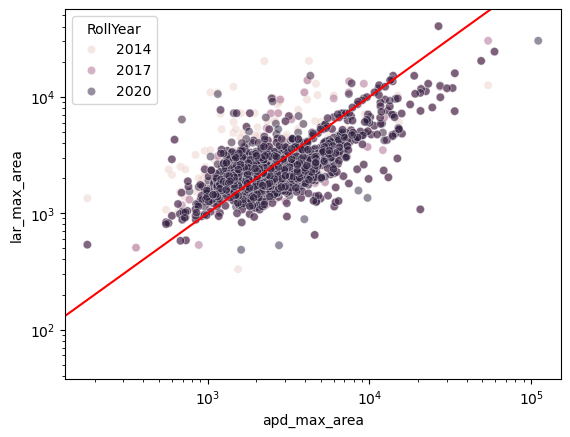

In [309]:
import seaborn as sns

ax = sns.scatterplot(data=all_results.query('apd_size == 1').reset_index(),
            #  x = 'apd_n_structures',y = 'lar_n_structures', 
            #  x = 'apd_gross_area',y = 'lar_gross_area', 
             x = 'apd_max_area',y = 'lar_max_area', 
             alpha = .5,
            #  scatter_kws={'s':1},
             hue = 'RollYear')

ax.axline((0, 0), slope=1., color='r', label='by slope')

plt.xscale('log'), plt.yscale('log')

Text(0.5, 0.98, 'LARIAC vs APD building size and counts mapped to landbase parcels')

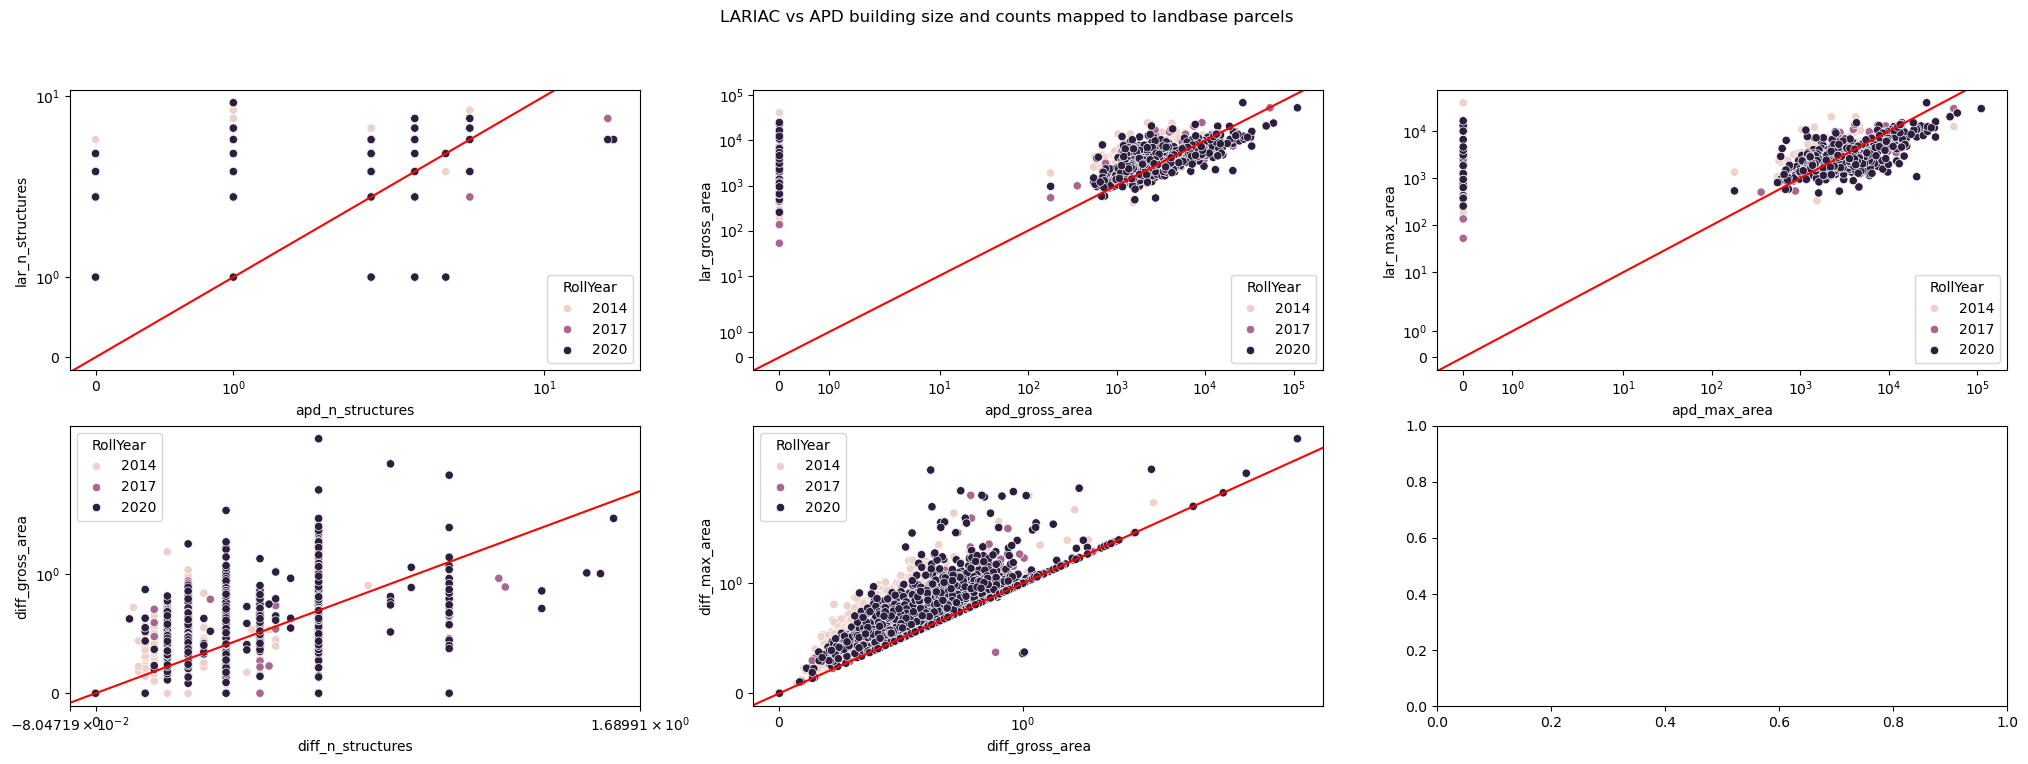

In [321]:
import seaborn as sns
x_vars = ['apd_n_structures', 'apd_gross_area', 'apd_max_area', 'diff_n_structures', 'diff_gross_area']
y_vars = ['lar_n_structures', 'lar_gross_area', 'lar_max_area', 'diff_gross_area', 'diff_max_area']
year = '2014'
d = all_results.reset_index()

f, ax = plt.subplots(2,3, figsize = (25,8))
ax = ax.flatten()
for ax, x,y in zip(ax, x_vars, y_vars):
    sns.scatterplot(
        data = d,
        x = x,
        y = y,
        hue = 'RollYear',
        ax = ax, #size=1, alpha=0.5
    )
    ax.axline((0, 0), slope=1., color='r', label='by slope')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

plt.suptitle('LARIAC vs APD building size and counts mapped to landbase parcels')

<Axes: >

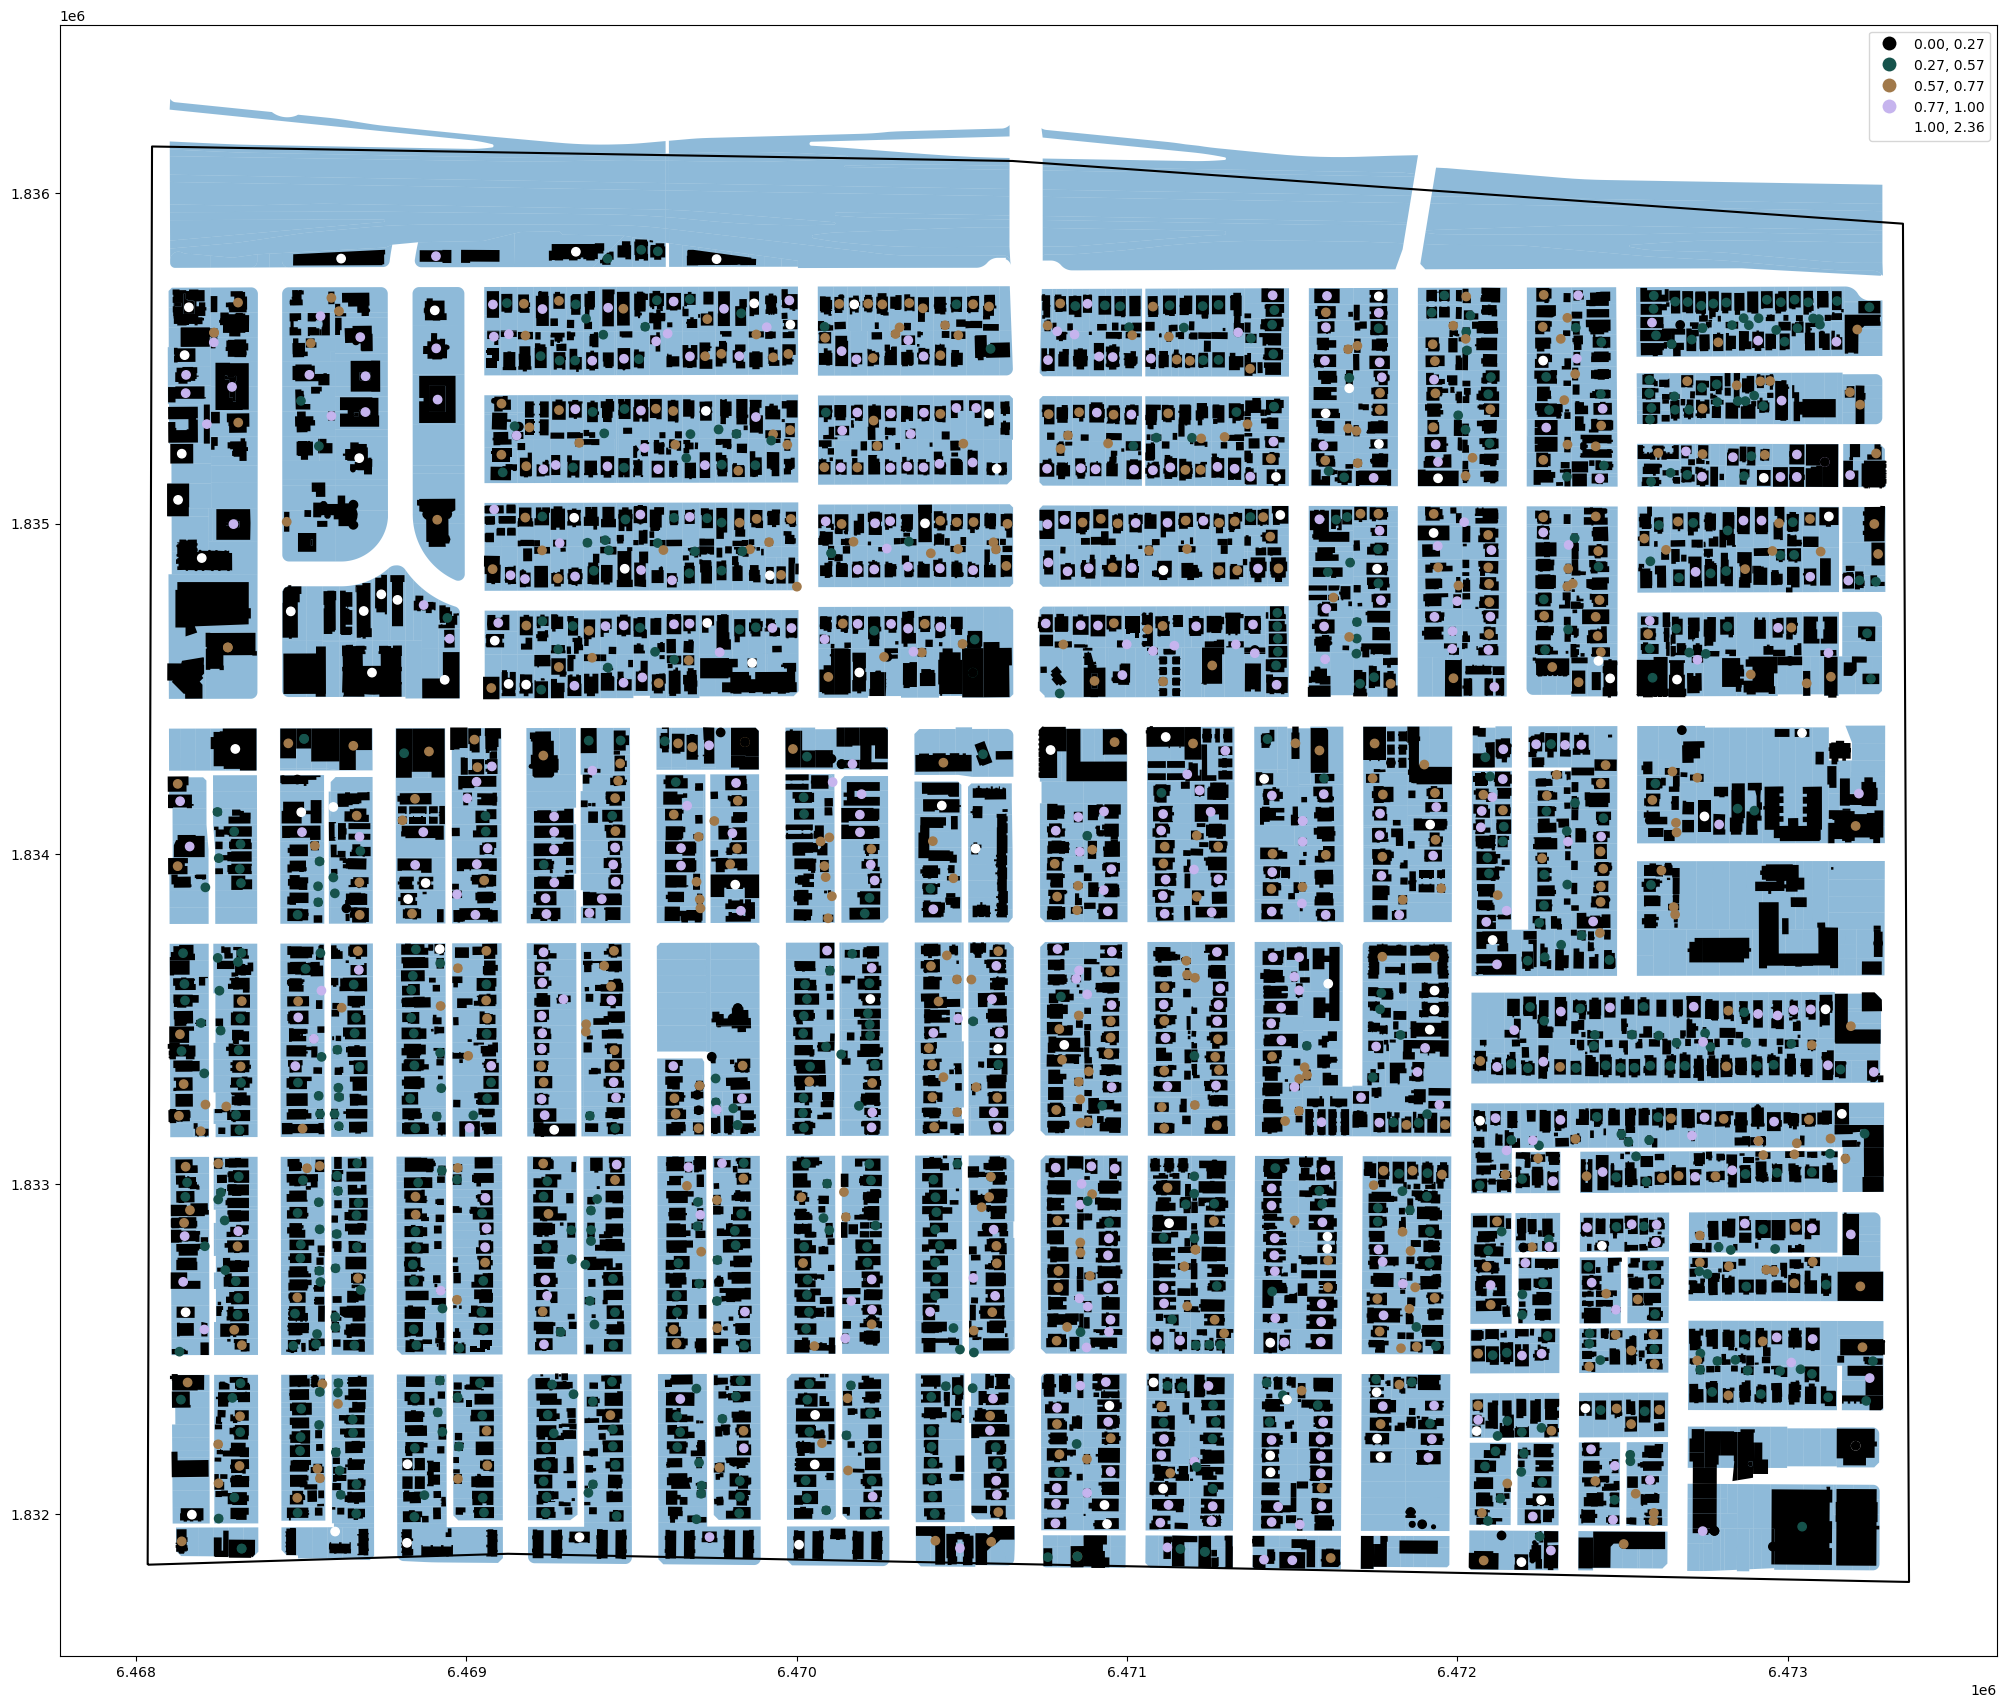

In [268]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize = (25,25))

lacity_hood.to_crs(landbase_parcels.crs).boundary.plot(color = 'k', ax = ax)
landbase_parcels.plot(alpha = .5, ax = ax)
lariac_structures.plot(ax = ax, color = 'k')
# assessor_data.plot(ax = ax, color = 'r')

results.set_geometry(results.centroid).plot('diff_gross_area', 
                                            legend =True, 
                                            scheme= 'naturalbreaks', 
                                            # markersize= 1,
                                            cmap = 'cubehelix',
                                            ax = ax)